In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import ast
import os
import re
from sklearn.linear_model import LinearRegression

# Read runtimes from logfiles

In [3]:
def read_all_logfiles_in_directory(logfile_directory):
    runtimes = {}
    for logfile_name in os.listdir(logfile_directory):
        model = logfile_name.replace(".log", "")
        logfile_full_path = os.path.join(logfile_directory, logfile_name)
        with open(logfile_full_path, 'r') as f:
            for line in f:
                m = re.match(r'Runtime for (.*): (\d+\.\d+) seconds', line)
                if m is not None:
                    label = ast.literal_eval(m.group(1))
                    label['model'] = model
                    runtime = float(m.group(2))
                    runtimes[(label['model'], label['num_input_tokens'],
                              label['num_output_tokens'])] = runtime
    return runtimes

In [4]:
v100_runtimes = read_all_logfiles_in_directory("logs/v100")
a100_runtimes = read_all_logfiles_in_directory("logs/a100")

# Plot runtimes for each model

In [5]:
def plot_per_model_runtimes(runtimes, model, all_num_input_tokens):
    print(model)

    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    for num_input_tokens in all_num_input_tokens:
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_input_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                [y for (_, y) in num_output_tokens_and_runtimes],
                label=f"input_tokens={num_input_tokens}",
                marker='o')

    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel("Number of output tokens")
    ax.set_ylabel("Runtime (seconds)")
    plt.legend(frameon=False)    
    sns.despine()
    plt.show()

gptj_6b


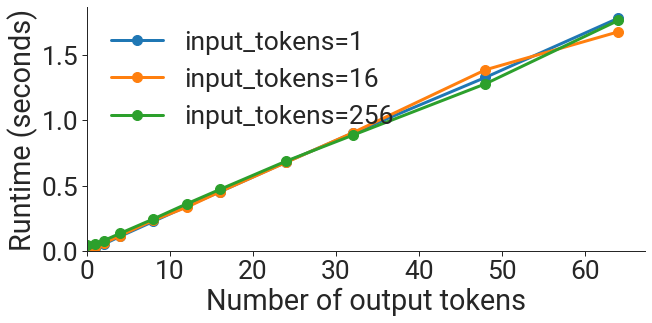

openai_ada


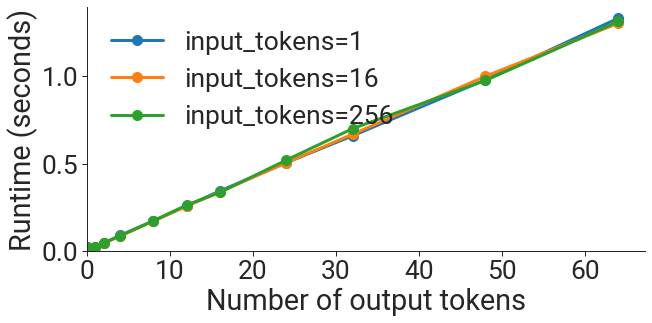

openai_davinci


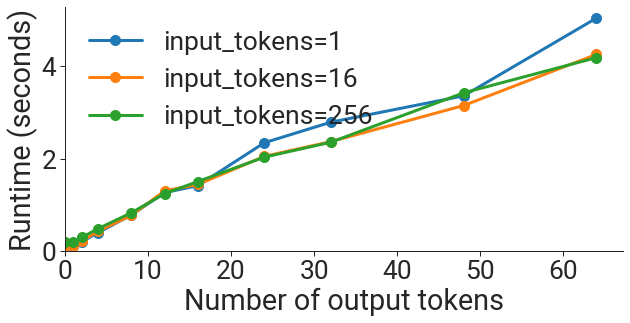

ai21_j1_jumbo


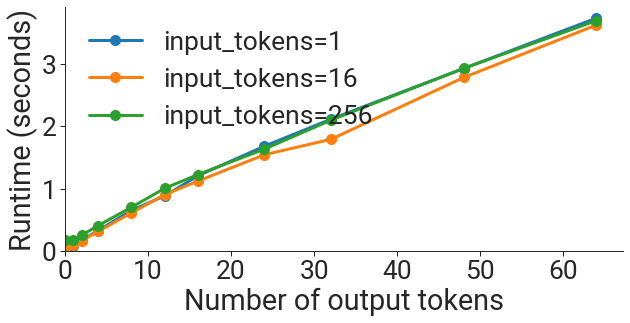

In [6]:
# Plot V100 runtimes.
plot_per_model_runtimes(v100_runtimes, 'gptj_6b', [1, 16, 256])
plot_per_model_runtimes(v100_runtimes, 'openai_ada', [1, 16, 256])
plot_per_model_runtimes(v100_runtimes, 'openai_davinci', [1, 16, 256])
plot_per_model_runtimes(v100_runtimes, 'ai21_j1_jumbo', [1, 16, 256])

gptj_6b


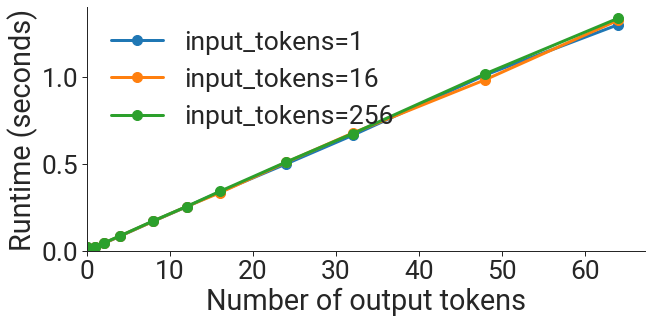

openai_ada


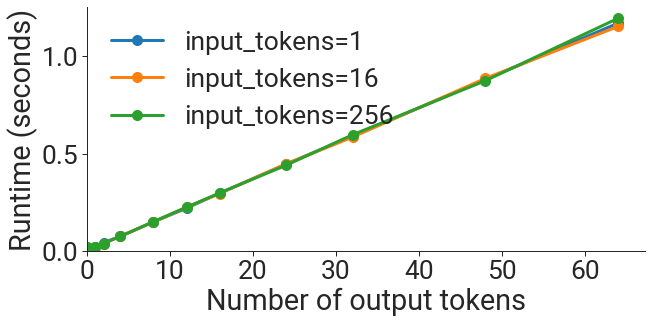

openai_davinci


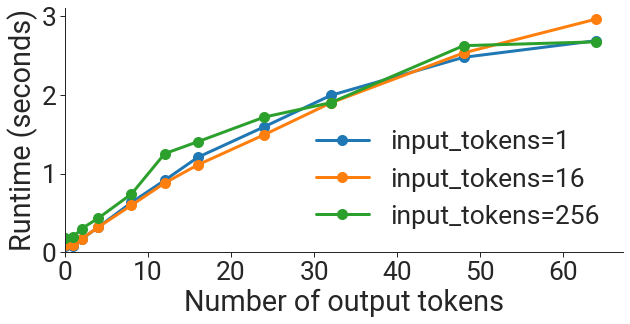

ai21_j1_jumbo


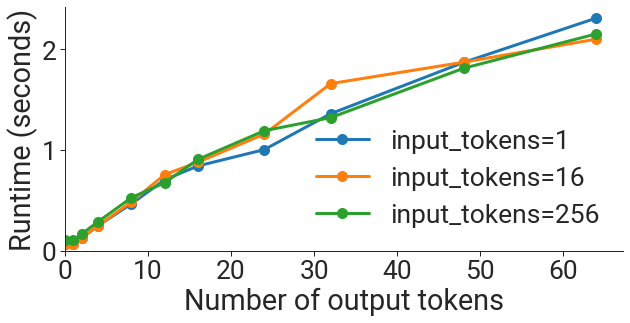

In [7]:
# Plot A100 runtimes.
plot_per_model_runtimes(a100_runtimes, 'gptj_6b', [1, 16, 256])
plot_per_model_runtimes(a100_runtimes, 'openai_ada', [1, 16, 256])
plot_per_model_runtimes(a100_runtimes, 'openai_davinci', [1, 16, 256])
plot_per_model_runtimes(a100_runtimes, 'ai21_j1_jumbo', [1, 16, 256])

# Plot runtimes for each number of input tokens

In [8]:
def plot_per_num_input_tokens_runtimes(runtimes, models, num_input_tokens):
    print(f"Number of input tokens: {num_input_tokens}")

    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    for model in models:
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_input_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                [y for (_, y) in num_output_tokens_and_runtimes],
                label=f"{model}",
                marker='o')

    ax.set_xlim(0, None)
    ax.set_ylim(0, 7)
    ax.set_xlabel("Number of output tokens")
    ax.set_ylabel("Runtime (seconds)")
    plt.legend(frameon=False, loc='upper left', ncol=2)    
    sns.despine()
    plt.show()

Number of input tokens: 1


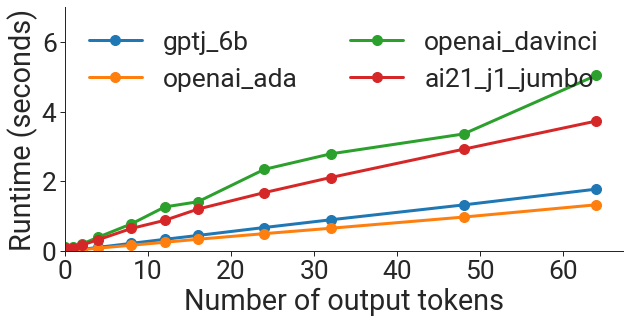

Number of input tokens: 16


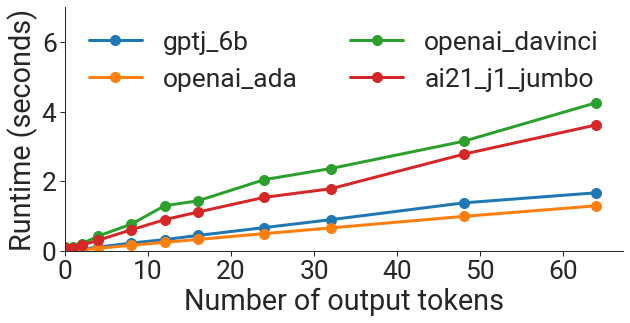

Number of input tokens: 256


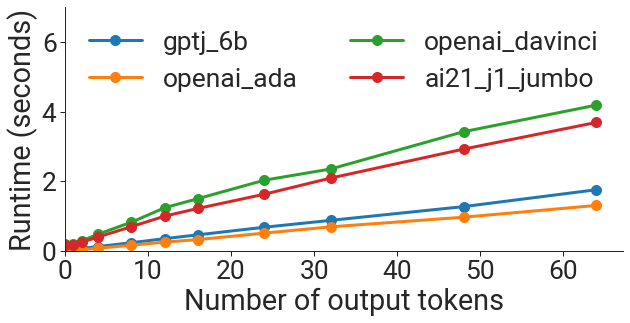

In [9]:
# Plot V100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_jumbo"]
plot_per_num_input_tokens_runtimes(v100_runtimes, models, 1)
plot_per_num_input_tokens_runtimes(v100_runtimes, models, 16)
plot_per_num_input_tokens_runtimes(v100_runtimes, models, 256)

Number of input tokens: 1


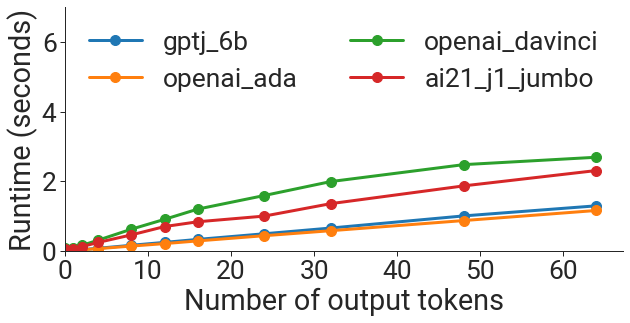

Number of input tokens: 16


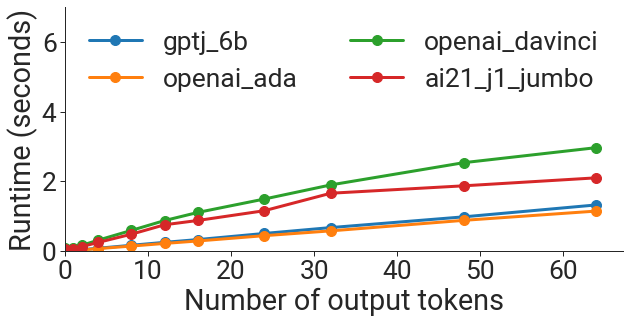

Number of input tokens: 256


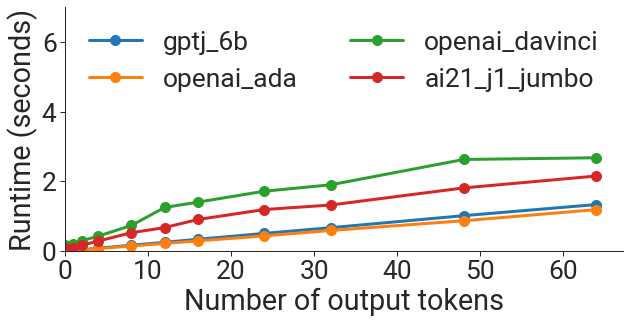

In [10]:
# Plot A100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_jumbo"]
plot_per_num_input_tokens_runtimes(a100_runtimes, models, 1)
plot_per_num_input_tokens_runtimes(a100_runtimes, models, 16)
plot_per_num_input_tokens_runtimes(a100_runtimes, models, 256)

# Get best-fit lines (slope and intercept)

In [11]:
def compute_best_fit(runtimes, models, num_input_tokens):
    print(f"Number of input tokens: {num_input_tokens}")
    for model in models:
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_input_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        X = [[x] for (x, _) in num_output_tokens_and_runtimes]
        Y = [y for (_, y) in num_output_tokens_and_runtimes]
        reg = LinearRegression()
        reg.fit(X, Y)
        cost_per_output_token = reg.coef_[0]
        cost_all_input_tokens = reg.intercept_
        print(f"{model}:\n\tcost per output token = {cost_per_output_token:.3f}"
              f"\n\tcost for {num_input_tokens} input token(s) = {cost_all_input_tokens:.3f}")
    print()

In [12]:
# Compute best fit for V100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo"]
compute_best_fit(v100_runtimes, models, 1)
compute_best_fit(v100_runtimes, models, 16)
compute_best_fit(v100_runtimes, models, 256)

Number of input tokens: 1
gptj_6b:
	cost per output token = 0.028
	cost for 1 input token(s) = 0.009
openai_ada:
	cost per output token = 0.020
	cost for 1 input token(s) = 0.010
openai_davinci:
	cost per output token = 0.075
	cost for 1 input token(s) = 0.182
ai21_j1_large:
	cost per output token = 0.025
	cost for 1 input token(s) = 0.019
ai21_j1_jumbo:
	cost per output token = 0.058
	cost for 1 input token(s) = 0.149

Number of input tokens: 16
gptj_6b:
	cost per output token = 0.027
	cost for 16 input token(s) = 0.022
openai_ada:
	cost per output token = 0.020
	cost for 16 input token(s) = 0.012
openai_davinci:
	cost per output token = 0.064
	cost for 16 input token(s) = 0.246
ai21_j1_large:
	cost per output token = 0.026
	cost for 16 input token(s) = 0.019
ai21_j1_jumbo:
	cost per output token = 0.055
	cost for 16 input token(s) = 0.130

Number of input tokens: 256
gptj_6b:
	cost per output token = 0.027
	cost for 256 input token(s) = 0.036
openai_ada:
	cost per output token = 0.02

In [13]:
# Compute best fit for A100 runtimes.
models = ["gptj_6b", "openai_ada", "openai_davinci", "ai21_j1_large", "ai21_j1_jumbo"]
compute_best_fit(a100_runtimes, models, 1)
compute_best_fit(a100_runtimes, models, 16)
compute_best_fit(a100_runtimes, models, 256)

Number of input tokens: 1
gptj_6b:
	cost per output token = 0.020
	cost for 1 input token(s) = 0.011
openai_ada:
	cost per output token = 0.018
	cost for 1 input token(s) = 0.008
openai_davinci:
	cost per output token = 0.044
	cost for 1 input token(s) = 0.256
ai21_j1_large:
	cost per output token = 0.023
	cost for 1 input token(s) = 0.012
ai21_j1_jumbo:
	cost per output token = 0.036
	cost for 1 input token(s) = 0.145

Number of input tokens: 16
gptj_6b:
	cost per output token = 0.021
	cost for 16 input token(s) = 0.010
openai_ada:
	cost per output token = 0.018
	cost for 16 input token(s) = 0.009
openai_davinci:
	cost per output token = 0.047
	cost for 16 input token(s) = 0.198
ai21_j1_large:
	cost per output token = 0.022
	cost for 16 input token(s) = 0.016
ai21_j1_jumbo:
	cost per output token = 0.034
	cost for 16 input token(s) = 0.201

Number of input tokens: 256
gptj_6b:
	cost per output token = 0.021
	cost for 256 input token(s) = 0.010
openai_ada:
	cost per output token = 0.01